# Fiddler working notebook for Churn usecase



1. Connect to Fiddler
2. Upload a baseline dataset
3. Add your model with Fiddler and create a surrogate model
4. Publish production events
5. Run prediction and explanation on a sample data point

## 0. Imports

In [ ]:
!pip3 install -q fiddler-client;

import numpy as np
import pandas as pd
import fiddler as fdl
import sklearn
import time

print(f"Running client version {fdl.__version__}")

In [ ]:
RANDOM_STATE = 42

## 1. Connect to Fiddler

In [ ]:
URL = ''
AUTH_TOKEN = ''
ORG_ID = ''

client = fdl.FiddlerApi(
    url=URL,
    org_id=ORG_ID,
    auth_token=AUTH_TOKEN
)

In [ ]:
PROJECT_ID = 'imbalance_credit_card_fraud'

In [ ]:
MODEL_ID = 'imbalance_cc_fraud'
DATASET_ID = 'imbalance_cc_fraud_baseline'

In [ ]:
client.create_project(PROJECT_ID)

## 2. Upload a baseline dataset


In [ ]:
PATH_TO_BASELINE_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/imbalance_baseline_data_sample.csv'

baseline_df = pd.read_csv(PATH_TO_BASELINE_CSV)
baseline_df.head()

In [ ]:
baseline_df['Class'].value_counts()

In [ ]:
print('Percentage of minority class: {}%'.format(round(baseline_df['Class'].value_counts()[1]*100/baseline_df.shape[0], 4)))


In [ ]:
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=100)
dataset_info

In [ ]:
client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={
        'baseline': baseline_df
    },
    info=dataset_info
)

## 3. Add your model and create a surrogate model


In [ ]:
CLASS_WEIGHT = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(baseline_df['Class']), y=baseline_df['Class']).tolist()
print(f'Computed class-weights: {CLASS_WEIGHT}')

Now, we will add two models - 
1. With class weight parameters
2. Without class weight parameters

In [ ]:
BINARY_THRESHOLD = 0.4
TARGET_COL = 'Class'
OUTPUT_COL = 'prediction_score'

Below, we first create a `ModelInfo` object and then add the two models.

In [ ]:
for mid in [MODEL_ID + '_weighted', MODEL_ID]:
    if 'weighted' in mid:
        weighting_params = fdl.core_objects.WeightingParams(class_weight=CLASS_WEIGHT)
        print(f'Add surrogate model with weighting parameters.')
    else:
        weighting_params = None
        print(f'Add surrogate model without weighting parameters.')
    target_col = TARGET_COL
    output_col = OUTPUT_COL
    inp_features = set(baseline_df.columns) - set([target_col, output_col])
    
    # Create ModelInfo object
    model_info = fdl.ModelInfo.from_dataset_info(
        dataset_info=dataset_info,
        target=target_col,
        dataset_id= DATASET_ID,
        features=inp_features,
        display_name='Fraud model',
        description='Fraud model with predictions in baseline',
        input_type=fdl.core_objects.ModelInputType.TABULAR,
        model_task=fdl.core_objects.ModelTask.BINARY_CLASSIFICATION,
        outputs=output_col,
        weighting_params=weighting_params,
        binary_classification_threshold=BINARY_THRESHOLD,
        categorical_target_class_details=[0, 1],

    )
    
    # Add Model and create surrogate model
    if mid not in client.list_models(project_id=PROJECT_ID):
        client.add_model(project_id=PROJECT_ID, model_id=mid, dataset_id=DATASET_ID, model_info=model_info)
        client.add_model_surrogate(project_id=PROJECT_ID, model_id=mid)
    else:
        print(f'Model: {mid} already exists in Project: {PROJECT_ID}')



## 4. Publish production events

In [ ]:
PATH_TO_EVENTS_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/imbalance_production_data.csv'

production_df = pd.read_csv(PATH_TO_EVENTS_CSV)
production_df.head()

In [ ]:
print('Percentage of minority class: {}%'.format(round(production_df['Class'].value_counts()[1]*100/production_df.shape[0], 4)))


We see that the percentage of minority class in production data is > 3 times than that of baseline data. This should create a big drift in the predictions

We will now publish the same production data for both the model, i.e. with class weights and without class weights

In [ ]:
for mid in [MODEL_ID + '_weighted', MODEL_ID]:
    t0 = time.time()
    print('Publishing events for Model ID: {}'.format(mid))
    client.publish_events_batch(
        project_id=PROJECT_ID,
        model_id=mid,
        batch_source=production_df,
        timestamp_field='timestamp'
    )
    t1 = time.time()
    dt = t1-t0
    print(f'Time required: {dt} secs for {len(production_df)} events. [{len(production_df)/dt} events/sec]')

## 5. Get insights

**You're all done!**

Run the following code block to get your URL.

In [ ]:
print('/'.join([URL, 'projects', PROJECT_ID, 'models', MODEL_ID, 'monitor']))

*Please allow 3-5 minutes for monitoring data to populate the charts.*

## 6. Monitoring Output

We see if we do not declare class weights the drift is low (`<=0.05`)

<table>
    <tr>
        <td>
            <img src="https://github.com/fiddler-labs/fiddler-examples/raw/main/quickstart/images/unweighted_dr.png" />
        </td>
    </tr>
</table>

whereas, if we declare class weights then we see a higher drift which is more correct respresentation if the production data where the ratio of minority is class is 3x

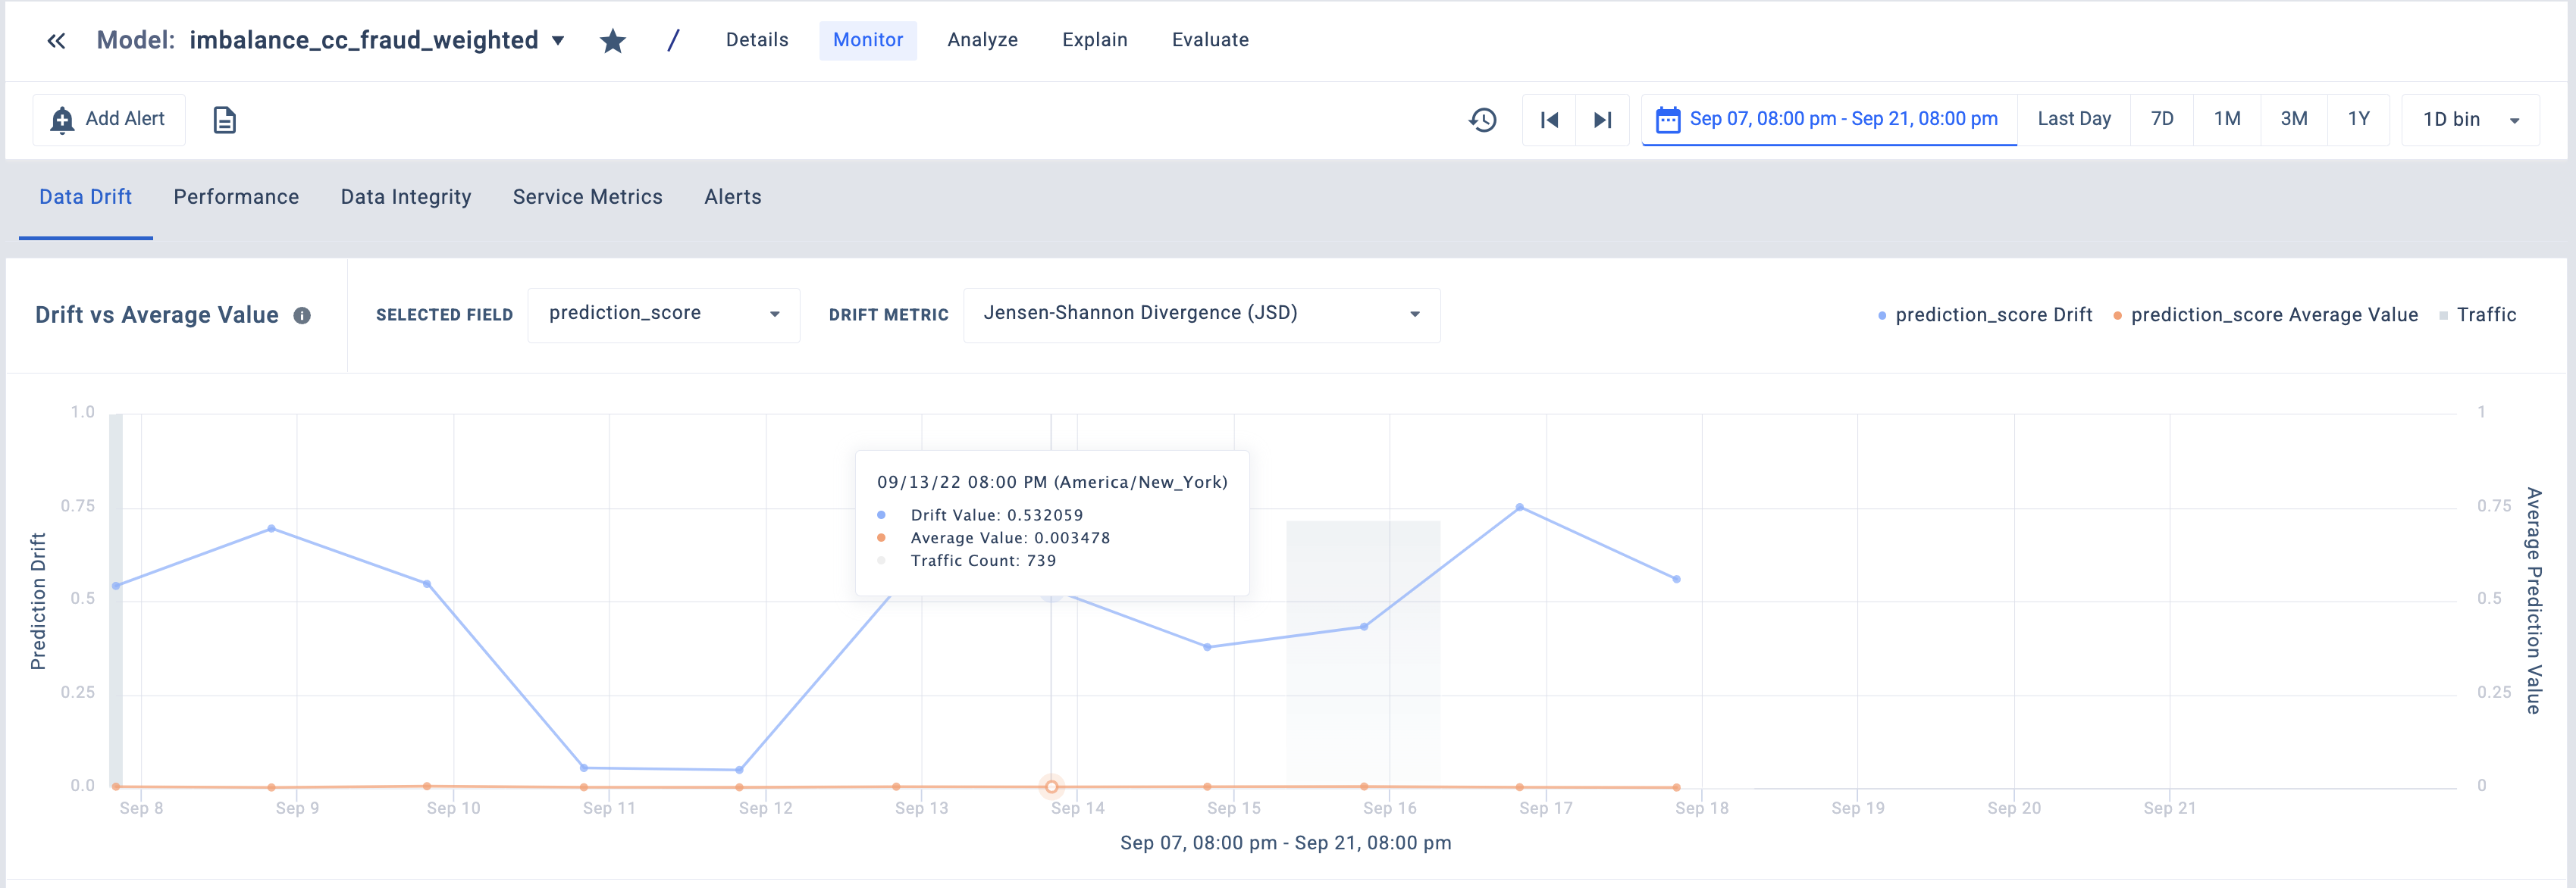



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.